In [3]:
import pandas as pd 
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('../data/robotarm.csv')

In [6]:
df['error_sequence'] = df['error'].apply(lambda x: "error" if x > 0 else "no_error")

In [7]:
df['cases']

0        none
1        none
2       case2
3        none
4        none
        ...  
5382     none
5383     none
5384     none
5385     none
5386     none
Name: cases, Length: 5387, dtype: object

In [8]:
for idx, row in df.iterrows():
    if row['cases'] == 'none':
        df.loc[idx, 'case_sequence'] = 'none'
    else:
        df.loc[idx, 'case_sequence'] = 'case'

In [10]:
df.to_csv('../data/robotarm_2.csv', index=False)

## Preparing data

* we should separate the data into the three tasks 

We have 3 features: 
* error space
* world space
* code space 

To make the model simpler: 
* categorize the distances into low and high: 
    * we decide to split the data following the distribution

Preprocessing: 
* Remove the values where index=0: it is the starting point, so everyone has the same and it does not give any insight
* Remove students that did less than 2 tentatives, because the model will not be able to learn correctly 

In [5]:
df_l1 = df[df['activity'] == 1]
df_l2 = df[df['activity'] == 2]
df_l3 = df[df['activity'] == 3]

In [174]:
len(df), len(df_l1), len(df_l2), len(df_l3), len(df_l1['Student ID'].unique()), len(df_l2['Student ID'].unique()), len(df_l3['Student ID'].unique())

(5387, 1642, 1738, 953, 306, 258, 198)

In [175]:
df_clean = df[df['index'] != 0]
df_clean = df_clean[df_clean['nb_tentative'] >= 2]

In [176]:
df_l1 = df_clean[df_clean['activity'] == 1]
df_l2 = df_clean[df_clean['activity'] == 2]
df_l3 = df_clean[df_clean['activity'] == 3]

len(df_clean), len(df_l1), len(df_l2), len(df_l3), len(df_l1['Student ID'].unique()), len(df_l2['Student ID'].unique()), len(df_l3['Student ID'].unique())

(4333, 1642, 1738, 953, 306, 258, 198)

In [177]:
def create_sequences(df): 
    df_student = df.groupby("Student ID")
    world_seq = []

    for student, data in df_student:
        student_seq = []
        for idx, row in data.iterrows():
            student_seq.append(row['bucket_delta_successive'])
            
        world_seq.append(student_seq)
        
    return world_seq


def prepare_data(df): 
    df_l1 = df[df['activity'] == 1]
    df_l2 = df[df['activity'] == 2]
    df_l3 = df[df['activity'] == 3]
    
    world_seq_l1 = create_sequences(df_l1)
    world_seq_l2 = create_sequences(df_l2)
    world_seq_l3 = create_sequences(df_l3)
    
    world_sequences = world_seq_l1 + world_seq_l2 + world_seq_l3
    return world_sequences

In [10]:
world_seq = prepare_data(df_clean)

In [11]:
world_seq_train = world_seq[:int(0.8*len(world_seq))]
world_seq_test = world_seq[int(0.8*len(world_seq)):]
world_seq_valid = world_seq_test[:int(0.5*len(world_seq_test))]

In [12]:
len(world_seq_train), len(world_seq_test), len(world_seq_valid)

(609, 153, 76)

In [13]:
def create_dataset(sequences):
    X = []
    y = []
    for seq in sequences:
        for i in range(1, len(seq)):
            X.append(seq[:i])
            y.append(seq[i])
    return X, y

In [14]:
X_train, y_train = create_dataset(world_seq_train)
X_test, y_test = create_dataset(world_seq_test)
X_valid, y_valid = create_dataset(world_seq_valid)

In [15]:
len(X_train), len(y_train), len(X_test), len(y_test), len(X_valid), len(y_valid)

(3004, 3004, 567, 567, 307, 307)

In [16]:
max_len = max(len(seq) for seq in X_train)
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='pre')
y_train = np.array(y_train)

X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='pre')
y_test = np.array(y_test)

X_valid_padded = pad_sequences(X_valid, maxlen=max_len, padding='pre')
y_valid = np.array(y_valid)


In [17]:
X_train_padded.shape, y_train.shape

((3004, 29), (3004,))

## Base Model : Predicting world space, with features only the world space 

In [39]:
X_train = torch.tensor(X_train_padded, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test_padded, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_valid = torch.tensor(X_valid_padded, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

### Logistic Regression

In [40]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

In [41]:
num_epochs = 200
loss_train_arr = []
loss_valid_arr = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train_arr.append(loss.item())
        
    # evaluate validation set and loss and accuracy at every 10th epoch
    with torch.no_grad():
        outputs = model(X_valid)
        loss_valid = criterion(outputs, y_valid.view(-1, 1))
        preds_valid = torch.round(outputs)
        accuracy_valid = (preds_valid == y_valid.view(-1, 1)).sum() / len(y_valid)
        loss_valid_arr.append(loss_valid.item())
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss Valid: {loss_valid.item():.4f}, Accuracy Valid: {accuracy_valid.item():.4f}')


Epoch [10/200], Loss: 0.6734, Loss Valid: 0.6599, Accuracy Valid: 0.6091
Epoch [20/200], Loss: 0.6615, Loss Valid: 0.6680, Accuracy Valid: 0.5993
Epoch [30/200], Loss: 0.6565, Loss Valid: 0.6646, Accuracy Valid: 0.6091
Epoch [40/200], Loss: 0.6546, Loss Valid: 0.6683, Accuracy Valid: 0.5993
Epoch [50/200], Loss: 0.6542, Loss Valid: 0.6686, Accuracy Valid: 0.6026
Epoch [60/200], Loss: 0.6542, Loss Valid: 0.6693, Accuracy Valid: 0.5993
Epoch [70/200], Loss: 0.6541, Loss Valid: 0.6691, Accuracy Valid: 0.5993
Epoch [80/200], Loss: 0.6541, Loss Valid: 0.6685, Accuracy Valid: 0.6026
Epoch [90/200], Loss: 0.6540, Loss Valid: 0.6685, Accuracy Valid: 0.5993
Epoch [100/200], Loss: 0.6540, Loss Valid: 0.6683, Accuracy Valid: 0.6026
Epoch [110/200], Loss: 0.6540, Loss Valid: 0.6682, Accuracy Valid: 0.6026
Epoch [120/200], Loss: 0.6540, Loss Valid: 0.6683, Accuracy Valid: 0.6026
Epoch [130/200], Loss: 0.6540, Loss Valid: 0.6684, Accuracy Valid: 0.6026
Epoch [140/200], Loss: 0.6540, Loss Valid: 0.66

In [42]:
# Evaluate the model
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.round(outputs)
    accuracy = (predicted == y_test.view(-1, 1)).sum().item() / len(y_test)
    fpr, tpr, thresholds = roc_curve(y_test.numpy(), outputs.numpy())
    roc_auc = auc(fpr, tpr)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'ROC AUC: {roc_auc:.4f}')


Accuracy: 62.08%
ROC AUC: 0.5234


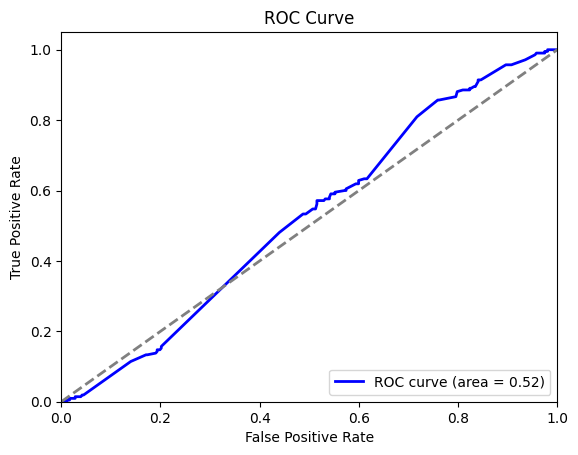

In [43]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

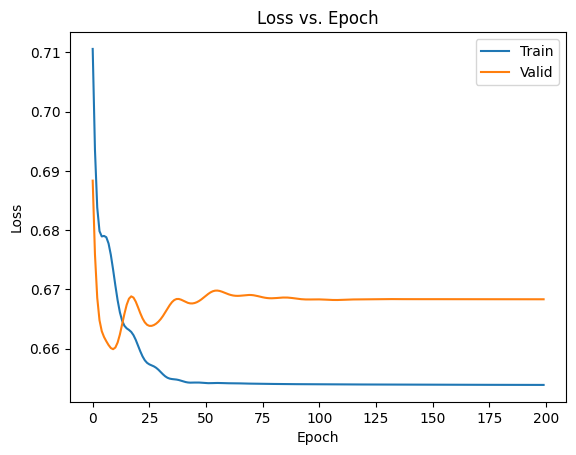

In [44]:
plt.plot(loss_train_arr, label='Train')
plt.plot(loss_valid_arr, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

### Cross validation

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Mean AUC: 0.51
Standard Deviation of AUC: 0.02
Mean Accuracy: 0.62
Standard Deviation of Accuracy: 0.02


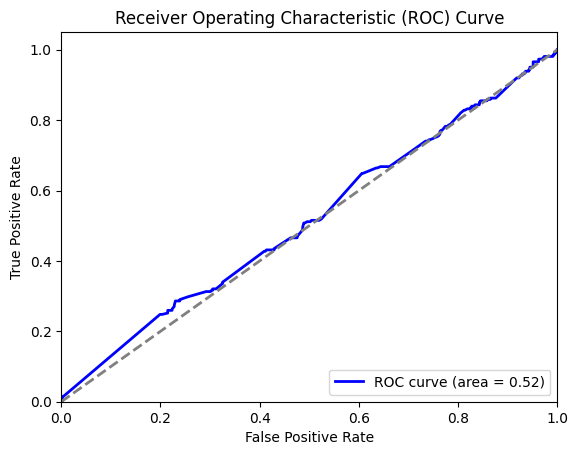

In [261]:
# Cross-validation setup
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store results
auc_scores = []


X, y = create_dataset(world_seq)

max_len = max(len(seq) for seq in X)
X_padded = pad_sequences(X, maxlen=max_len, padding='pre')
y = np.array(y)

X = torch.tensor(X_padded, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

auc_scores = []
acc_scores = []

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Initialize model, loss function, and optimizer
    input_dim = X_train.shape[1]
    model = LogisticRegressionModel(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.05)
    
    # Train the model
    num_epochs = 200
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train.view(-1, 1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = torch.round(outputs)
        accuracy = (predicted == y_test.view(-1, 1)).sum().item() / len(y_test)
        fpr, tpr, thresholds = roc_curve(y_test.numpy(), outputs.numpy())
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        acc_scores.append(accuracy)
        

# Print mean and standard deviation of AUC scores
print(f'Mean AUC: {np.mean(auc_scores):.2f}')
print(f'Standard Deviation of AUC: {np.std(auc_scores):.2f}')

print(f'Mean Accuracy: {np.mean(acc_scores):.2f}')
print(f'Standard Deviation of Accuracy: {np.std(acc_scores):.2f}')

# Plot the ROC curve for the last fold
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### LSTM Model

In [29]:
X_train = torch.tensor(X_train_padded, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test_padded, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_valid = torch.tensor(X_valid_padded, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

In [30]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)
        c0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

In [31]:
input_dim = 1  # Since we are dealing with sequences of single digits
hidden_dim = 50
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Train the model
num_epochs = 200
X_train = X_train.unsqueeze(-1)  # Add feature dimension
X_test = X_test.unsqueeze(-1)  # Add feature dimension
X_valid = X_valid.unsqueeze(-1)  # Add feature dimension

loss_train_arr = []
loss_valid_arr = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_train_arr.append(loss.item())
        
    # evaluate validation set and loss and accuracy at every 10th epoch
    with torch.no_grad():
        outputs = model(X_valid)
        loss_valid = criterion(outputs, y_valid.view(-1, 1))
        preds_valid = torch.round(outputs)
        accuracy_valid = (preds_valid == y_valid.view(-1, 1)).sum() / len(y_valid)
        loss_valid_arr.append(loss_valid.item())
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss Valid: {loss_valid.item():.4f}, Accuracy Valid: {accuracy_valid.item():.4f}')

Epoch [10/200], Loss: 0.6698, Loss Valid: 0.6727, Accuracy Valid: 0.6091
Epoch [20/200], Loss: 0.6638, Loss Valid: 0.6670, Accuracy Valid: 0.6091
Epoch [30/200], Loss: 0.6584, Loss Valid: 0.6668, Accuracy Valid: 0.6091
Epoch [40/200], Loss: 0.6579, Loss Valid: 0.6651, Accuracy Valid: 0.6091
Epoch [50/200], Loss: 0.6571, Loss Valid: 0.6636, Accuracy Valid: 0.6091
Epoch [60/200], Loss: 0.6567, Loss Valid: 0.6625, Accuracy Valid: 0.6091
Epoch [70/200], Loss: 0.6565, Loss Valid: 0.6614, Accuracy Valid: 0.6091
Epoch [80/200], Loss: 0.6565, Loss Valid: 0.6616, Accuracy Valid: 0.6091
Epoch [90/200], Loss: 0.6559, Loss Valid: 0.6617, Accuracy Valid: 0.6091
Epoch [100/200], Loss: 0.6562, Loss Valid: 0.6604, Accuracy Valid: 0.6091
Epoch [110/200], Loss: 0.6538, Loss Valid: 0.6600, Accuracy Valid: 0.6091
Epoch [120/200], Loss: 0.6578, Loss Valid: 0.6629, Accuracy Valid: 0.6091
Epoch [130/200], Loss: 0.6572, Loss Valid: 0.6624, Accuracy Valid: 0.6091
Epoch [140/200], Loss: 0.6565, Loss Valid: 0.66

Accuracy: 62.96%
ROC AUC: 0.5550


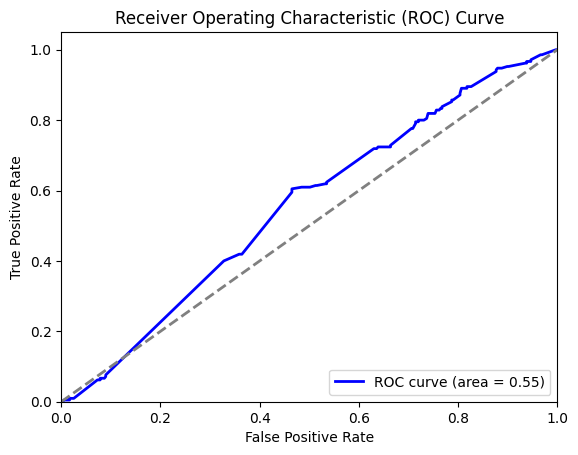

In [32]:
# Evaluate the model and compute ROC curve
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.round(outputs)
    accuracy = (predicted == y_test.view(-1, 1)).sum().item() / len(y_test)
    fpr, tpr, thresholds = roc_curve(y_test.numpy(), outputs.numpy())
    roc_auc = auc(fpr, tpr)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'ROC AUC: {roc_auc:.4f}')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Mean AUC: 0.56
Standard Deviation of AUC: 0.03
Mean Accuracy: 0.61
Standard Deviation of Accuracy: 0.02


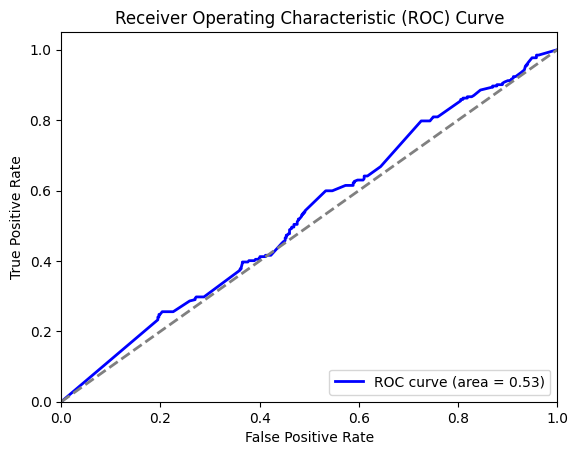

In [47]:
# Cross-validation setup
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store results
auc_scores = []


X, y = create_dataset(world_seq)

max_len = max(len(seq) for seq in X)
X_padded = pad_sequences(X, maxlen=max_len, padding='pre')
y = np.array(y)

X = torch.tensor(X_padded, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

auc_scores = []
acc_scores = []

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = X_train.unsqueeze(-1)
    X_test = X_test.unsqueeze(-1)

    # Initialize model, loss function, and optimizer
    input_dim = 1
    hidden_dim = 50
    output_dim = 1
    model = LSTMModel(input_dim, hidden_dim, output_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.05)
    
    # Train the model
    num_epochs = 200
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train.view(-1, 1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = torch.round(outputs)
        accuracy = (predicted == y_test.view(-1, 1)).sum().item() / len(y_test)
        fpr, tpr, thresholds = roc_curve(y_test.numpy(), outputs.numpy())
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        acc_scores.append(accuracy)
        

# Print mean and standard deviation of AUC scores
print(f'Mean AUC: {np.mean(auc_scores):.2f}')
print(f'Standard Deviation of AUC: {np.std(auc_scores):.2f}')

print(f'Mean Accuracy: {np.mean(acc_scores):.2f}')
print(f'Standard Deviation of Accuracy: {np.std(acc_scores):.2f}')

# Plot the ROC curve for the last fold
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 1. Model prediction: features are error space, world space and code space, to predict the world space

In [53]:
def create_sequences_v2(df): 
    df_student = df.groupby("Student ID")
    world_seq = []
    code_seq = []
    error_seq = []

    for student, data in df_student:
        student_world_seq = []
        student_code_seq = []
        student_error_seq = []
        for idx, row in data.iterrows():
            student_world_seq.append(row['bucket_delta_successive'])
            student_code_seq.append(row['bucket_Submission_TreeDist_Successive'])
            student_error_seq.append(row['error'])
            
        world_seq.append(student_world_seq)
        code_seq.append(student_code_seq)
        error_seq.append(student_error_seq)
        
    return world_seq, code_seq, error_seq


def prepare_data_v2(df): 
    df_l1 = df[df['activity'] == 1]
    df_l2 = df[df['activity'] == 2]
    df_l3 = df[df['activity'] == 3]
    
    world_seq_l1, code_seq_l1, error_seq_l1 = create_sequences_v2(df_l1)
    world_seq_l2, code_seq_l2, error_seq_l2  = create_sequences_v2(df_l2)
    world_seq_l3, code_seq_l3, error_seq_l3 = create_sequences_v2(df_l3)
    
    world_sequences = world_seq_l1 + world_seq_l2 + world_seq_l3
    code_sequences = code_seq_l1 + code_seq_l2 + code_seq_l3
    error_sequences = error_seq_l1 + error_seq_l2 + error_seq_l3
    return world_sequences, code_sequences, error_sequences

In [54]:
world_seq, code_seq, error_seq = prepare_data_v2(df_clean)

In [55]:
world_seq_train = world_seq[:int(0.8*len(world_seq))]
code_seq_train = code_seq[:int(0.8*len(world_seq))]
error_seq_train = error_seq[:int(0.8*len(world_seq))]

world_seq_test = world_seq[int(0.8*len(world_seq)):]
code_seq_test = code_seq[int(0.8*len(world_seq)):]
error_seq_test = error_seq[int(0.8*len(world_seq)):]

world_seq_valid = world_seq_test[:int(0.5*len(world_seq_test))]
code_seq_valid = code_seq_test[:int(0.5*len(world_seq_test))]
error_seq_valid = error_seq_test[:int(0.5*len(world_seq_test))]

In [61]:
def create_dataset_v2(world_sequences, code_sequences, error_sequences):
    X = []
    y = []
    for world_seq, code_seq, error_seq in zip(world_sequences, code_sequences, error_sequences):
        for i in range(1, len(world_seq)):
            if i < len(world_seq):
                X.append(code_seq[:i+1] + error_seq[:i+1] + world_seq[:i])
                y.append(world_seq[i])
    return X, y

In [62]:
X_train, y_train = create_dataset_v2(world_seq_train, code_seq_train, error_seq_train)
X_test, y_test = create_dataset_v2(world_seq_test, code_seq_test, error_seq_test)
X_valid, y_valid = create_dataset_v2(world_seq_valid, code_seq_valid, error_seq_valid)

In [63]:
len(X_train), len(y_train), len(X_test), len(y_test), len(X_valid), len(y_valid)

(3004, 3004, 567, 567, 307, 307)

In [64]:
X_train

[[1, 0, 0, 1, 1],
 [1, 0, 1, 0, 1, 0, 1, 1],
 [1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1],
 [1, 0, 1, 1, 1],
 [1, 0, 0, 1, 1, 1, 1, 1],
 [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
 [1, 1, 0, 0, 1],
 [1, 0, 0, 1, 1],
 [1, 0, 1, 0, 1, 1, 1, 0],
 [1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
 [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0],
 [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
 [1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0],
 [1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
 [1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0],
 [1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0],
 [1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0],
 [1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [115]:
max_len = max(len(seq) for seq in X_train)
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='pre')
y_train = np.array(y_train)

X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='pre')
y_test = np.array(y_test)

X_valid_padded = pad_sequences(X_valid, maxlen=max_len, padding='pre')
y_valid = np.array(y_valid)


In [116]:
X_train_padded.shape, y_train.shape

((3004, 89), (3004,))

In [129]:
X_train = torch.tensor(X_train_padded, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test_padded, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_valid = torch.tensor(X_valid_padded, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

In [130]:
input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.01)

In [131]:
num_epochs = 300
loss_train_arr = []
loss_valid_arr = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train_arr.append(loss.item())
        
    # evaluate validation set and loss and accuracy at every 10th epoch
    with torch.no_grad():
        outputs = model(X_valid)
        loss_valid = criterion(outputs, y_valid.view(-1, 1))
        preds_valid = torch.round(outputs)
        accuracy_valid = (preds_valid == y_valid.view(-1, 1)).sum() / len(y_valid)
        loss_valid_arr.append(loss_valid.item())
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss Valid: {loss_valid.item():.4f}, Accuracy Valid: {accuracy_valid.item():.4f}')


Epoch [10/300], Loss: 0.6802, Loss Valid: 0.6764, Accuracy Valid: 0.6156
Epoch [20/300], Loss: 0.6730, Loss Valid: 0.6672, Accuracy Valid: 0.6091
Epoch [30/300], Loss: 0.6709, Loss Valid: 0.6665, Accuracy Valid: 0.6091
Epoch [40/300], Loss: 0.6694, Loss Valid: 0.6666, Accuracy Valid: 0.6091
Epoch [50/300], Loss: 0.6677, Loss Valid: 0.6647, Accuracy Valid: 0.6091
Epoch [60/300], Loss: 0.6664, Loss Valid: 0.6627, Accuracy Valid: 0.6091
Epoch [70/300], Loss: 0.6655, Loss Valid: 0.6619, Accuracy Valid: 0.6091
Epoch [80/300], Loss: 0.6649, Loss Valid: 0.6616, Accuracy Valid: 0.6091
Epoch [90/300], Loss: 0.6644, Loss Valid: 0.6614, Accuracy Valid: 0.6091
Epoch [100/300], Loss: 0.6640, Loss Valid: 0.6612, Accuracy Valid: 0.6091
Epoch [110/300], Loss: 0.6636, Loss Valid: 0.6611, Accuracy Valid: 0.6091
Epoch [120/300], Loss: 0.6634, Loss Valid: 0.6611, Accuracy Valid: 0.6091
Epoch [130/300], Loss: 0.6631, Loss Valid: 0.6610, Accuracy Valid: 0.6091
Epoch [140/300], Loss: 0.6630, Loss Valid: 0.66

In [132]:
# Evaluate the model
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.round(outputs)
    accuracy = (predicted == y_test.view(-1, 1)).sum().item() / len(y_test)
    fpr, tpr, thresholds = roc_curve(y_test.numpy(), outputs.numpy())
    roc_auc = auc(fpr, tpr)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'ROC AUC: {roc_auc:.4f}')


Accuracy: 62.96%
ROC AUC: 0.5732


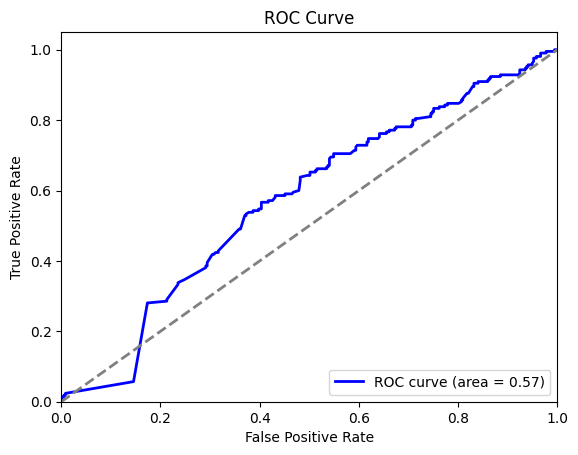

In [133]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

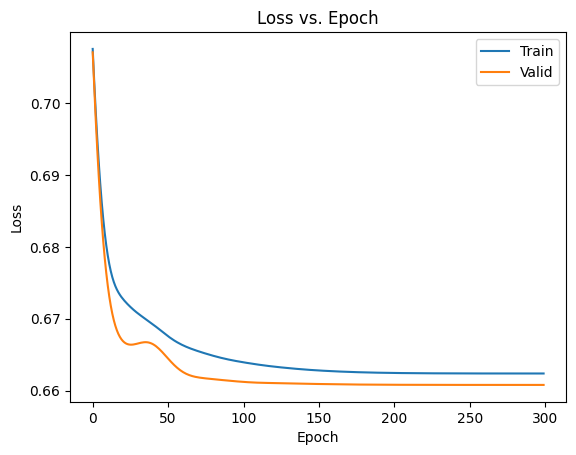

In [134]:
plt.plot(loss_train_arr, label='Train')
plt.plot(loss_valid_arr, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

### Let's try with LSTM

In [164]:
X_train, y_train = create_dataset_v2(world_seq_train, code_seq_train, error_seq_train)
X_test, y_test = create_dataset_v2(world_seq_test, code_seq_test, error_seq_test)
X_valid, y_valid = create_dataset_v2(world_seq_valid, code_seq_valid, error_seq_valid)

max_len = max(len(seq) for seq in X_train)
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='pre')
y_train = np.array(y_train)

X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='pre')
y_test = np.array(y_test)

X_valid_padded = pad_sequences(X_valid, maxlen=max_len, padding='pre')
y_valid = np.array(y_valid)

X_train = torch.tensor(X_train_padded, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test_padded, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_valid = torch.tensor(X_valid_padded, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

In [165]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)
        c0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

In [166]:
input_dim = 1  # Since we are dealing with sequences of single digits
hidden_dim = 100
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 200
X_train = X_train.unsqueeze(-1)  # Add feature dimension
X_test = X_test.unsqueeze(-1)  # Add feature dimension
X_valid = X_valid.unsqueeze(-1)  # Add feature dimension

In [167]:
loss_train_arr = []
loss_valid_arr = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_train_arr.append(loss.item())
        
    # evaluate validation set and loss and accuracy at every 10th epoch
    with torch.no_grad():
        outputs = model(X_valid)
        loss_valid = criterion(outputs, y_valid.view(-1, 1))
        preds_valid = torch.round(outputs)
        accuracy_valid = (preds_valid == y_valid.view(-1, 1)).sum() / len(y_valid)
        loss_valid_arr.append(loss_valid.item())
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss Valid: {loss_valid.item():.4f}, Accuracy Valid: {accuracy_valid.item():.4f}')

Epoch [10/200], Loss: 0.6733, Loss Valid: 0.6739, Accuracy Valid: 0.6091
Epoch [20/200], Loss: 0.6646, Loss Valid: 0.6683, Accuracy Valid: 0.6091
Epoch [30/200], Loss: 0.6619, Loss Valid: 0.6675, Accuracy Valid: 0.6091
Epoch [40/200], Loss: 0.6571, Loss Valid: 0.6667, Accuracy Valid: 0.6091
Epoch [50/200], Loss: 0.6571, Loss Valid: 0.6641, Accuracy Valid: 0.6091
Epoch [60/200], Loss: 0.6557, Loss Valid: 0.6634, Accuracy Valid: 0.6091
Epoch [70/200], Loss: 0.6508, Loss Valid: 0.6607, Accuracy Valid: 0.6547
Epoch [80/200], Loss: 0.6496, Loss Valid: 0.6588, Accuracy Valid: 0.6482
Epoch [90/200], Loss: 0.6487, Loss Valid: 0.6622, Accuracy Valid: 0.6612
Epoch [100/200], Loss: 0.6395, Loss Valid: 0.6569, Accuracy Valid: 0.6384
Epoch [110/200], Loss: 0.6281, Loss Valid: 0.6716, Accuracy Valid: 0.6026
Epoch [120/200], Loss: 0.6188, Loss Valid: 0.6543, Accuracy Valid: 0.6547
Epoch [130/200], Loss: 0.6127, Loss Valid: 0.6477, Accuracy Valid: 0.6710
Epoch [140/200], Loss: 0.6073, Loss Valid: 0.62

Accuracy: 65.08%
ROC AUC: 0.6497


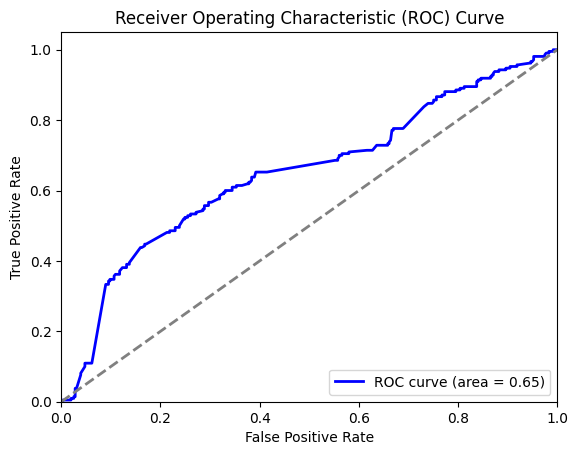

In [168]:
# Evaluate the model and compute ROC curve
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.round(outputs)
    accuracy = (predicted == y_test.view(-1, 1)).sum().item() / len(y_test)
    fpr, tpr, thresholds = roc_curve(y_test.numpy(), outputs.numpy())
    roc_auc = auc(fpr, tpr)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'ROC AUC: {roc_auc:.4f}')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

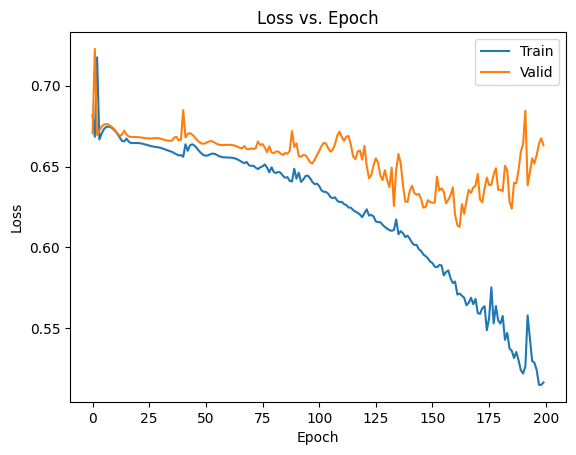

In [169]:
plt.plot(loss_train_arr, label='Train')
plt.plot(loss_valid_arr, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

### 3. Model prediction: features are error space and code space, and we predict the world space

In [250]:
world_seq, code_seq, error_seq = prepare_data_v2(df_clean)

In [251]:
world_seq_train = world_seq[:int(0.8*len(world_seq))]
code_seq_train = code_seq[:int(0.8*len(world_seq))]
error_seq_train = error_seq[:int(0.8*len(world_seq))]

world_seq_test = world_seq[int(0.8*len(world_seq)):]
code_seq_test = code_seq[int(0.8*len(world_seq)):]
error_seq_test = error_seq[int(0.8*len(world_seq)):]

world_seq_valid = world_seq_test[:int(0.5*len(world_seq_test))]
code_seq_valid = code_seq_test[:int(0.5*len(world_seq_test))]
error_seq_valid = error_seq_test[:int(0.5*len(world_seq_test))]

In [252]:
def create_dataset_v3(world_sequences, code_sequences, error_sequences):
    X = []
    y = []
    for world_seq, code_seq, error_seq in zip(world_sequences, code_sequences, error_sequences):
        for i in range(1, len(world_seq)):
            if i < len(world_seq):
                X.append(code_seq[:i+1] + error_seq[:i+1])
                y.append(world_seq[i])
    return X, y

In [253]:
X_train, y_train = create_dataset_v3(world_seq_train, code_seq_train, error_seq_train)
X_test, y_test = create_dataset_v3(world_seq_test, code_seq_test, error_seq_test)
X_valid, y_valid = create_dataset_v3(world_seq_valid, code_seq_valid, error_seq_valid)

In [254]:
len(X_train), len(y_train), len(X_test), len(y_test), len(X_valid), len(y_valid)

(3004, 3004, 567, 567, 307, 307)

In [255]:
max_len = max(len(seq) for seq in X_train)
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='pre')
y_train = np.array(y_train)

X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='pre')
y_test = np.array(y_test)

X_valid_padded = pad_sequences(X_valid, maxlen=max_len, padding='pre')
y_valid = np.array(y_valid)


In [256]:
X_train_padded.shape, y_train.shape

((3004, 60), (3004,))

In [257]:
X_train = torch.tensor(X_train_padded, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test_padded, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_valid = torch.tensor(X_valid_padded, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

In [258]:
input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)

In [259]:
num_epochs = 300
loss_train_arr = []
loss_valid_arr = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train_arr.append(loss.item())
        
    # evaluate validation set and loss and accuracy at every 10th epoch
    with torch.no_grad():
        outputs = model(X_valid)
        loss_valid = criterion(outputs, y_valid.view(-1, 1))
        preds_valid = torch.round(outputs)
        accuracy_valid = (preds_valid == y_valid.view(-1, 1)).sum() / len(y_valid)
        loss_valid_arr.append(loss_valid.item())
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss Valid: {loss_valid.item():.4f}, Accuracy Valid: {accuracy_valid.item():.4f}')


Epoch [10/300], Loss: 0.6740, Loss Valid: 0.6660, Accuracy Valid: 0.6091
Epoch [20/300], Loss: 0.6671, Loss Valid: 0.6577, Accuracy Valid: 0.6091
Epoch [30/300], Loss: 0.6604, Loss Valid: 0.6526, Accuracy Valid: 0.6091
Epoch [40/300], Loss: 0.6562, Loss Valid: 0.6454, Accuracy Valid: 0.6091
Epoch [50/300], Loss: 0.6529, Loss Valid: 0.6385, Accuracy Valid: 0.6124
Epoch [60/300], Loss: 0.6508, Loss Valid: 0.6347, Accuracy Valid: 0.6124
Epoch [70/300], Loss: 0.6494, Loss Valid: 0.6320, Accuracy Valid: 0.6938
Epoch [80/300], Loss: 0.6485, Loss Valid: 0.6300, Accuracy Valid: 0.6938
Epoch [90/300], Loss: 0.6479, Loss Valid: 0.6288, Accuracy Valid: 0.6938
Epoch [100/300], Loss: 0.6475, Loss Valid: 0.6280, Accuracy Valid: 0.7068
Epoch [110/300], Loss: 0.6472, Loss Valid: 0.6275, Accuracy Valid: 0.7068
Epoch [120/300], Loss: 0.6470, Loss Valid: 0.6272, Accuracy Valid: 0.7036
Epoch [130/300], Loss: 0.6469, Loss Valid: 0.6271, Accuracy Valid: 0.7003
Epoch [140/300], Loss: 0.6469, Loss Valid: 0.62

In [260]:
# Evaluate the model
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.round(outputs)
    accuracy = (predicted == y_test.view(-1, 1)).sum().item() / len(y_test)
    fpr, tpr, thresholds = roc_curve(y_test.numpy(), outputs.numpy())
    roc_auc = auc(fpr, tpr)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'ROC AUC: {roc_auc:.4f}')


Accuracy: 70.72%
ROC AUC: 0.6500


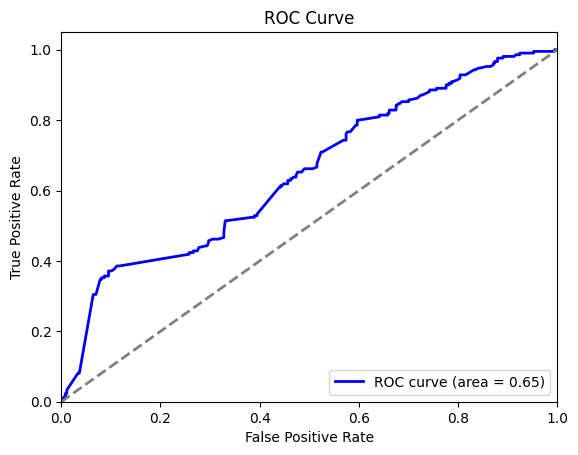

In [261]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

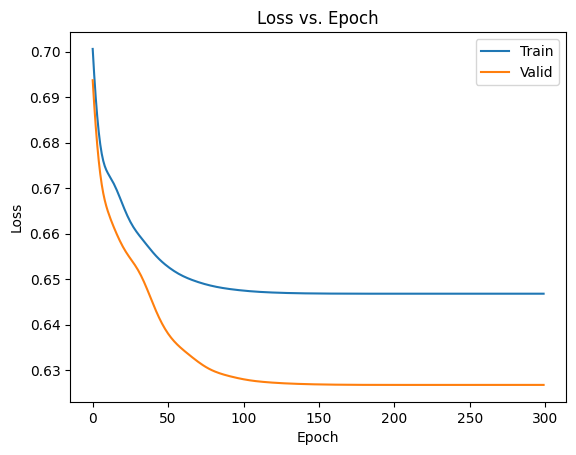

In [262]:
plt.plot(loss_train_arr, label='Train')
plt.plot(loss_valid_arr, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

#### Cross validation 

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Mean AUC: 0.60
Standard Deviation of AUC: 0.02
Mean Accuracy: 0.65
Standard Deviation of Accuracy: 0.02


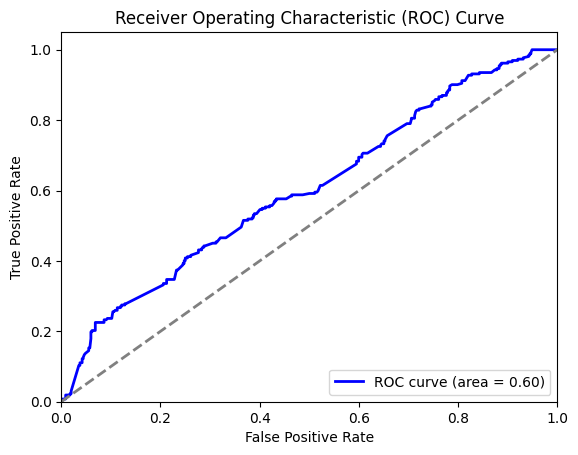

In [237]:
# Cross-validation setup
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store results
auc_scores = []


X, y = create_dataset_v3(world_seq, code_seq, error_seq)

max_len = max(len(seq) for seq in X)
X_padded = pad_sequences(X, maxlen=max_len, padding='pre')
y = np.array(y)

X = torch.tensor(X_padded, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

auc_scores = []
acc_scores = []

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Initialize model, loss function, and optimizer
    input_dim = X_train.shape[1]
    model = LogisticRegressionModel(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(),  lr=0.005, weight_decay=0.01)
    
    # Train the model
    num_epochs = 300
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train.view(-1, 1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = torch.round(outputs)
        accuracy = (predicted == y_test.view(-1, 1)).sum().item() / len(y_test)
        fpr, tpr, thresholds = roc_curve(y_test.numpy(), outputs.numpy())
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        acc_scores.append(accuracy)
        

# Print mean and standard deviation of AUC scores
print(f'Mean AUC: {np.mean(auc_scores):.2f}')
print(f'Standard Deviation of AUC: {np.std(auc_scores):.2f}')

print(f'Mean Accuracy: {np.mean(acc_scores):.2f}')
print(f'Standard Deviation of Accuracy: {np.std(acc_scores):.2f}')

# Plot the ROC curve for the last fold
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### LSTM

In [269]:
X_train, y_train = create_dataset_v3(world_seq_train, code_seq_train, error_seq_train)
X_test, y_test = create_dataset_v3(world_seq_test, code_seq_test, error_seq_test)
X_valid, y_valid = create_dataset_v3(world_seq_valid, code_seq_valid, error_seq_valid)

max_len = max(len(seq) for seq in X_train)
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='pre')
y_train = np.array(y_train)

X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='pre')
y_test = np.array(y_test)

X_valid_padded = pad_sequences(X_valid, maxlen=max_len, padding='pre')
y_valid = np.array(y_valid)

X_train = torch.tensor(X_train_padded, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test_padded, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_valid = torch.tensor(X_valid_padded, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

In [270]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)
        c0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

In [271]:
input_dim = 1  # Since we are dealing with sequences of single digits
hidden_dim = 100
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 150
X_train = X_train.unsqueeze(-1)  # Add feature dimension
X_test = X_test.unsqueeze(-1)  # Add feature dimension
X_valid = X_valid.unsqueeze(-1)  # Add feature dimension

In [272]:
loss_train_arr = []
loss_valid_arr = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_train_arr.append(loss.item())
        
    # evaluate validation set and loss and accuracy at every 10th epoch
    with torch.no_grad():
        outputs = model(X_valid)
        loss_valid = criterion(outputs, y_valid.view(-1, 1))
        preds_valid = torch.round(outputs)
        accuracy_valid = (preds_valid == y_valid.view(-1, 1)).sum() / len(y_valid)
        loss_valid_arr.append(loss_valid.item())
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss Valid: {loss_valid.item():.4f}, Accuracy Valid: {accuracy_valid.item():.4f}')

Epoch [10/150], Loss: 0.6779, Loss Valid: 0.6765, Accuracy Valid: 0.6091
Epoch [20/150], Loss: 0.6652, Loss Valid: 0.6665, Accuracy Valid: 0.6091
Epoch [30/150], Loss: 0.6638, Loss Valid: 0.6643, Accuracy Valid: 0.6091
Epoch [40/150], Loss: 0.6614, Loss Valid: 0.6593, Accuracy Valid: 0.6091
Epoch [50/150], Loss: 0.6544, Loss Valid: 0.6402, Accuracy Valid: 0.6059
Epoch [60/150], Loss: 0.6503, Loss Valid: 0.6289, Accuracy Valid: 0.6743
Epoch [70/150], Loss: 0.6441, Loss Valid: 0.6192, Accuracy Valid: 0.6938
Epoch [80/150], Loss: 0.6433, Loss Valid: 0.6218, Accuracy Valid: 0.6775
Epoch [90/150], Loss: 0.6310, Loss Valid: 0.6236, Accuracy Valid: 0.6384
Epoch [100/150], Loss: 0.6210, Loss Valid: 0.6138, Accuracy Valid: 0.6580
Epoch [110/150], Loss: 0.6131, Loss Valid: 0.6176, Accuracy Valid: 0.6515
Epoch [120/150], Loss: 0.6038, Loss Valid: 0.6224, Accuracy Valid: 0.6384
Epoch [130/150], Loss: 0.5965, Loss Valid: 0.6301, Accuracy Valid: 0.6710
Epoch [140/150], Loss: 0.5886, Loss Valid: 0.63

Accuracy: 66.49%
ROC AUC: 0.6609


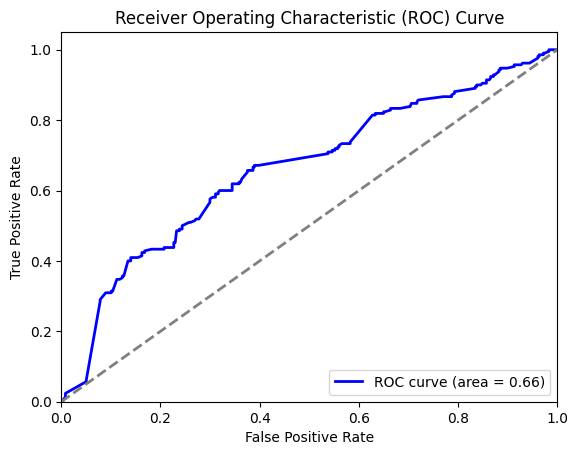

In [273]:
# Evaluate the model and compute ROC curve
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.round(outputs)
    accuracy = (predicted == y_test.view(-1, 1)).sum().item() / len(y_test)
    fpr, tpr, thresholds = roc_curve(y_test.numpy(), outputs.numpy())
    roc_auc = auc(fpr, tpr)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'ROC AUC: {roc_auc:.4f}')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

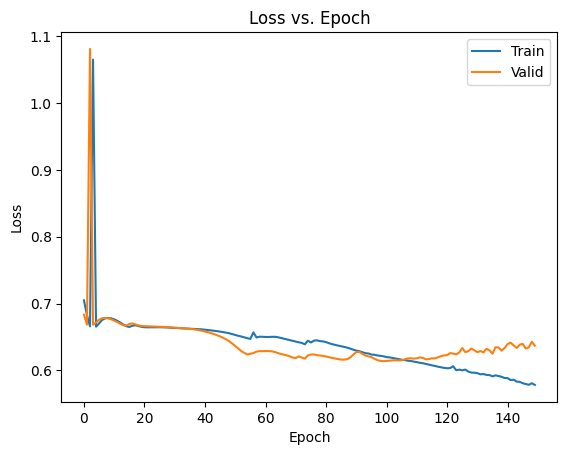

In [274]:
plt.plot(loss_train_arr, label='Train')
plt.plot(loss_valid_arr, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()